# Looking at and random sampling from the 1D-encoded latent space.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import markers
from random import uniform, choice
import absl.logging
import os
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras import models

In [2]:
ptarr = np.load("saves/1d_points.npy", allow_pickle=True)

### Representations during training for each digit.
Here we see the ranges of the representations for each digit throughout training.  
Note that while the loss eventually bottoms out by epoch 25 in 1d, nevertheless I trained the model to epoch 50 to stay consistent.
Notice that thankfully all the ranges cluster more or less around 0 and stay relatively similar in size. However digits 0 and 1 already show quite some deviation, which will become sharper in higher dimensions, as the class regions start moving apart.

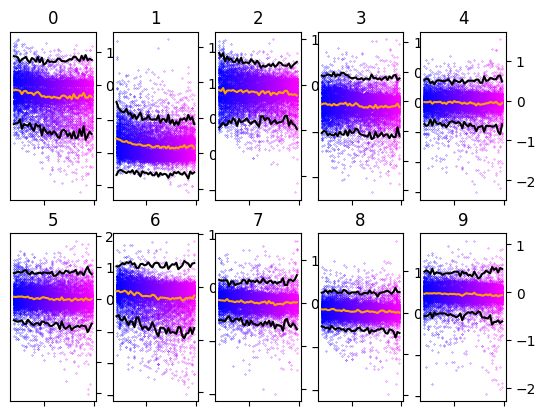

In [3]:
_, ax = plt.subplots(2, 5)

# 10, because the mappings during early training are quite wide (and meaningless) and dull the rest of the data
a, b = 10, len(ptarr)
xs = [[] for _ in range(10)]
for epoch in range(a, b):
    for dig in range(10):
        i, j = (dig - dig % 5) // 5, dig % 5
        x = ptarr[epoch][dig]
        y = [epoch for _ in range(len(ptarr[epoch][dig][0]))]
        xs[dig].append(x)

        ax[i, j].set_xticklabels([])
        ax[i, j].title.set_text(f"{dig}")
        ax[i, j].yaxis.tick_right()
        ax[i, j].scatter(y, x, s=0.05, color=[(epoch - a) / (b - a), 0, 1])

for dig in range(10):
    i, j = (dig - dig % 5) // 5, dig % 5
    ax[i, j].plot(range(a, b), [np.mean(k) for k in xs[dig]], color="orange")
    ax[i, j].plot(range(a, b), [np.mean(k) + 2 * np.std(k) for k in xs[dig]], color="black")
    ax[i, j].plot(range(a, b), [np.mean(k) - 2 * np.std(k) for k in xs[dig]], color="black")

plt.show()

### Final mapping regions for each digit
Here the deviations of digits 0 and 1 are much easier to see. Nevertheless they are still represented near 0 even if the regions are different from the rest.
Intuitively this makes perfect sense. Handwritten 1s differ more or less exclusively by just their angle, while 0s (ovals) are quite variable. They need smaller and larger, respectively, spaces to represent them well.

In [4]:
encoder1d = models.load_model("saved_models/encoder_1d", compile=False)

train_df = pd.read_csv("mnist/mnist_train.csv", header=None)
train_x = np.array(train_df.iloc[:, 1:].to_numpy().reshape((-1, 28, 28, 1)))
train_x = train_x/255.
train_y = np.array(train_df.iloc[:, 0].to_numpy().reshape((-1, 1)))

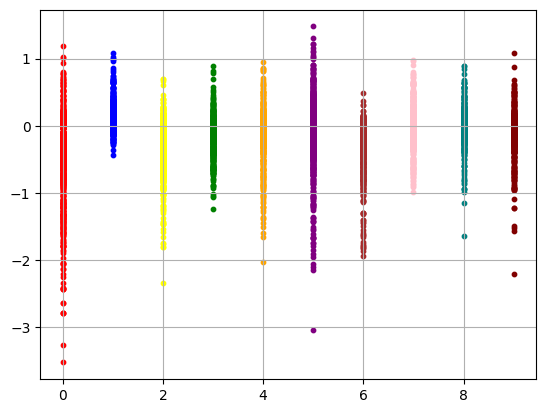

In [5]:
colors = ["red", "blue", "yellow", "green", "orange", "purple", "brown", "pink", "teal", "maroon"]
preds = {}
for dig in range(10):
    i, j = (dig - dig % 5) // 5, dig % 5
    dig_samp_xs, dig_samp_ys = [], []
    for _ in range(1000):
        ind = choice(range(len(train_x)))
        while train_y[ind].item() != dig:
            ind = choice(range(len(train_x)))

        dig_samp_xs.append(train_x[ind])
        dig_samp_ys.append(train_y[ind])

    dig_samp_xs = np.array(dig_samp_xs).reshape((-1, 28, 28, 1))
    dig_pred_xs = encoder1d.predict(dig_samp_xs, verbose=0)
    preds[dig] = dig_pred_xs.flatten()

    plt.scatter([dig] * len(dig_pred_xs), dig_pred_xs[:, 0], color=colors[dig], s=10)
plt.grid(True)
plt.show()

### Random sampling by class
Given the ranges seen above, it is clear that all classes are represented well even if by subsets, close to the origin. So we can sample from say \[-0.4, +0.4\]. While many of the outputs are mundane and similar-ish, this is to be expected while sampling from such a small space.

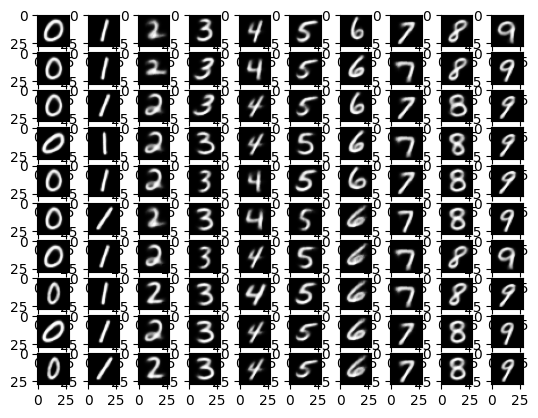

In [6]:
decoder2d = models.load_model("saved_models/decoder_1d", compile=False)
r = 0.4

_, ax2 = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        hotcode = [0] * 10
        hotcode[j] = 1
        sample = np.array([[uniform(-r, r), *hotcode]])
        pred = decoder2d.predict(sample, verbose=0)[0]
        ax2[i, j].imshow(pred, cmap="gray")
plt.show()